In [1]:
import numpy as np
from matplotlib import pyplot as plt
from os import listdir
import json

In [2]:
def get_y_val(x, xs, ys):
    for i in range(xs.shape[0]):
        if xs[i] > x:
            # This is upper bound, previous is lower bound
            if i == 0:
                end, start = xs[i], 0
                l = (x-start)/(end-start)
                return ys[i]#(l)*ys[i]
            end, start = xs[i], xs[i-1]
            l = (x-start)/(end-start)
            return (l)*ys[i] + (1-l)*ys[i-1]
    return ys[len(ys)-1]

In [3]:
def get_average_plot(data):
    end_time = 0
    for d in data:
        end_time = max(end_time, np.max(d[0]))
    xs = np.array(range(0, int(end_time)))
    yss = np.array([[get_y_val(x, d[0], d[1]) for x in xs] for d in data])
    ys_agv = np.sum(yss, axis=0) / yss.shape[0]
    ys_std = np.std(yss, axis=0)
    return xs, ys_agv, ys_std

def average_plot(data, color=(0.02745098, 0.50588235, 0.87058824), plot_std=True):
    xs, ys_avg, ys_std = get_average_plot(data)
    if plot_std:
        plt.fill_between(xs, ys_avg-ys_std, ys_avg+ys_std, color=(color[0], color[1], color[2], 0.25))
    plt.plot(xs, ys_avg, color=color)


In [18]:
def get_info(filename):
    parts = filename.replace(".json","").split("_")
    nodes = int(parts[0].split(":")[1])
    samples = int(parts[1].split(":")[1])
    epochs = int(parts[3].split(":")[1])
    sync_rate = float(parts[4].split(":")[1])
    return nodes, samples, epochs, sync_rate

def get_hash(nodes, samples, epochs, sync_rate):
    return "%s|%s|%s|%s"%(nodes, samples, epochs, sync_rate)
    
info_dict = {}
dirname = "../data/swarm_accuracy_data"
for filename in listdir(dirname):
    nodes, samples, epochs, sync_rate = get_info(filename)
    key = get_hash(nodes, samples, epochs, sync_rate)
    with open(dirname+"/"+filename, "r") as f:
        loaded = json.loads(f.read())
    loaded = [np.array(l) for l in loaded]
    if key in info_dict:
        info_dict[key].append(loaded)
    else:
        info_dict[key] = [loaded]
        
fed_info_dict = {}
dirname = "../data/fed_accuracy_data"
for filename in listdir(dirname):
    nodes, samples, epochs, sync_rate = get_info(filename)
    key = get_hash(nodes, samples, epochs, sync_rate)
    with open(dirname+"/"+filename, "r") as f:
        loaded = json.loads(f.read())
    loaded = [np.array(l) for l in loaded]
    if key in fed_info_dict:
        fed_info_dict[key].append(loaded)
    else:
        fed_info_dict[key] = [loaded]
        
def get_mixed_node_data(nodes, samples, epochs, sync_rate, is_swarm=True):
    if not is_swarm:
        sync_rate = 0.0
    h = get_hash(nodes, samples, epochs, sync_rate)
    data = []
    target_dict = info_dict if is_swarm else fed_info_dict
    for d in target_dict[h]:
        # Add all of this runs nodes to mixed data
        data.extend(d)
    return data

all_syncs = [0.9, 0.7, 0.5, 0.3, 0.1]
all_samples = [60000, 30000, 10000, 1000]
all_epochs = [3, 2, 1]

In [19]:
print(list(info_dict.keys()))
print(list(fed_info_dict.keys()))

['10|6000|1|0.2', '10|6000|1|0.4', '10|6000|1|0.8', '10|6000|1|0.6']
[]


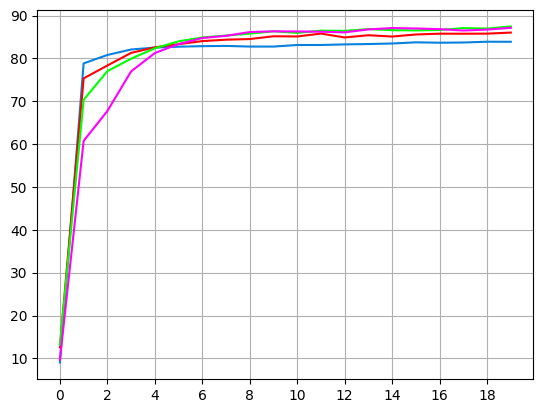

In [23]:
average_plot(get_mixed_node_data(10, 6000, 1, 0.2), plot_std=False)
average_plot(get_mixed_node_data(10, 6000, 1, 0.4), color=(1,0,0), plot_std=False)
average_plot(get_mixed_node_data(10, 6000, 1, 0.6), color=(0,1,0), plot_std=False)
average_plot(get_mixed_node_data(10, 6000, 1, 0.8), color=(1,0,1), plot_std=False)
plt.xticks(ticks=[x for x in range(0, 20, 2)])
plt.grid()
plt.show()

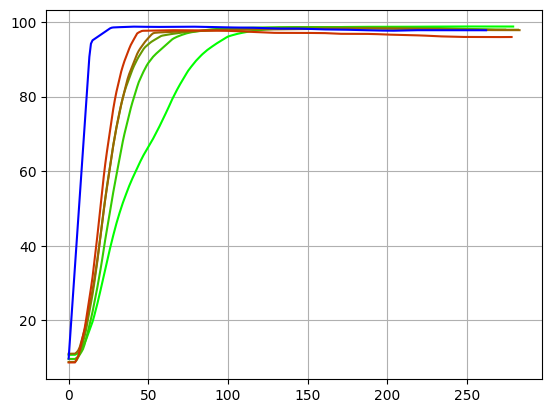

In [21]:
t=0
for s in all_syncs:
    average_plot(get_mixed_node_data(5, 60000, 1, s), color=(t,1-t,0), plot_std=False)
    t += 1/len(all_syncs)
average_plot(get_mixed_node_data(5, 60000, 1, 0, is_swarm=False), color=(0,0,1), plot_std=False)
plt.grid()
plt.show()
# The more red = lower sync rate

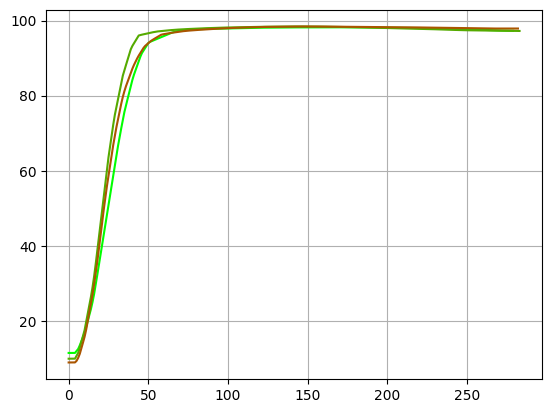

In [26]:
t=0
for s in all_epochs:
    average_plot(get_mixed_node_data(5, 60000, s, 0.5), color=(t,1-t,0), plot_std=False)
    t += 1/len(all_epochs)


plt.grid()
plt.show()
# The more red = less epochs

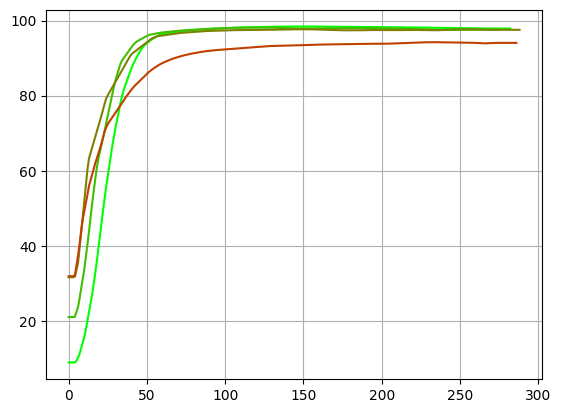

In [23]:
t=0
for s in all_samples:
    average_plot(get_mixed_node_data(5, s, 1, 0.5), color=(t,1-t,0), plot_std=False)
    t += 1/len(all_samples)


plt.grid()
plt.show()
# The more red = less samples

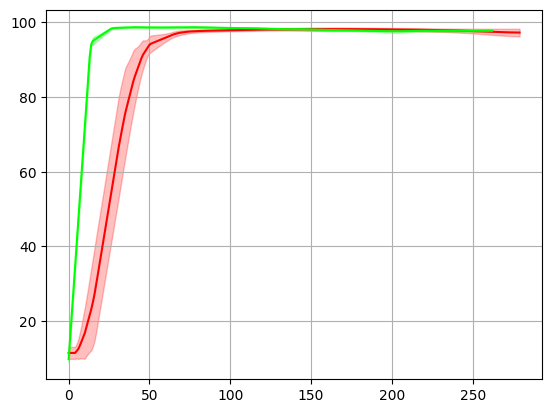

In [24]:
average_plot(get_mixed_node_data(5, 60000, 3, 0.5), color=(1,0,0), plot_std=True)
average_plot(get_mixed_node_data(5, 60000, 1, 0.0, is_swarm=False), color=(0,1,0), plot_std=True)
plt.grid()
plt.show()